In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import itertools
import collections
import pandas as pd
import random
import plotly.offline as offline
import plotly.plotly as py
import plotly.graph_objs as go


%matplotlib inline
offline.init_notebook_mode(connected=True)

In [2]:
Exp_Timeline = pd.read_csv("/home/tao/jupyter3/Tel_Data/Exp_TimeLine.csv")
ECG_meta = pd.read_csv("/home/tao/jupyter3/Tel_Data/ECG_MetaInfor.csv")
display(Exp_Timeline)
display(ECG_meta.head())

,Start,End,Label,Class
0,21-MAR-17,24-MAR-17,E06_Baseline_Time,1
1,12-APR-17,15-APR-17,E06_Peak_Time,0
2,27-JUL-16,30-JUL-16,E30_Baseline_Time,1
3,19-AUG-16,22-AUG-16,E30_Peak_Time,0
4,10-JAN-17,13-JAN-17,E07B_Baseline_Time,1
5,27-JAN-17,30-JAN-17,E07B_Peak_Time,0


,sub,desc1,tel,dtype,desc2,id,Exp,Species
0,196,Telemetry Collection from ECG Sensor for RIh16...,Telemetry,TEL_ECG,Telemetry Collection from ECG Sensor,1912,E06,RIh16
1,201,Telemetry Collection from ECG Sensor for RTe16...,Telemetry,TEL_ECG,Telemetry Collection from ECG Sensor,1915,E06,RTe16
2,206,Telemetry Collection from ECG Sensor for RCl15...,Telemetry,TEL_ECG,Telemetry Collection from ECG Sensor,1916,E06,RCl15
3,211,Telemetry Collection from ECG Sensor for RUf16...,Telemetry,TEL_ECG,Telemetry Collection from ECG Sensor,1918,E06,RUf16
4,220,Telemetry Collection from ECG Sensor for 12C13...,Telemetry,TEL_ECG,Telemetry Collection from ECG Sensor,1401,E07B,12C136


In [45]:
X_H0 = list()
Y_H0 = list()
### Baseline
for i in range(0, 13):
    dd = "/mnt/data0/tao/ECG/" + ECG_meta.Exp[i] + "/Baseline/" + ECG_meta.Species[i]
    file_hour = [x for x in os.listdir(dd) if '_H0_' in x]
    for item in file_hour:
        ff = dd + "/" + item
        data = pd.read_csv(ff)
        X_H0.append(list(data.VALUE.values))
        Y_H0.append(0)
### Peak
for i in range(0, 13):
    dd = "/mnt/data0/tao/ECG/" + ECG_meta.Exp[i] + "/Peak/" + ECG_meta.Species[i]
    file_hour = [x for x in os.listdir(dd) if '_H0_' in x]
    for item in file_hour:
        ff = dd + "/" + item
        data = pd.read_csv(ff)
        X_H0.append(list(data.VALUE.values))
        Y_H0.append(1)

In [53]:
X_H0 = np.asarray(X_H0)
Y_H0 = np.asarray(Y_H0)
print(np.shape(X_H0))
print(np.shape(Y_H0))

(9345, 10001)
(9345,)


In [54]:
print('Baseline # :', len([x for x in Y_H0 if x == 0]))
print('Peak # :', len([x for x in Y_H0 if x == 1]))

Baseline # : 3692
Peak # : 5653


In [48]:
x_train, x_test, y_train, y_test = train_test_split(X_H0, Y_H0, test_size=0.1)

print("x_train : ", len(x_train))
print("x_test  : ", len(x_test))
print("y_train : ", collections.Counter(y_train))
print("y_test  : ", collections.Counter(y_test))

x_train :  8410
x_test  :  935
y_train :  Counter({1: 5074, 0: 3336})
y_test  :  Counter({1: 579, 0: 356})


In [49]:
print(np.shape(x_train[0]))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))

(10001,)
(8410,)
(935, 10001)
(935,)


In [66]:
# Normalize
x_train = normalize(x_train, axis=0, norm='max')
x_test = normalize(x_test, axis=0, norm='max')

# Specify that all features have real-value data
feature_columns = [tf.feature_column.numeric_column("ecg", shape=np.shape(x_train[0]))]

# Build Classifier
estimator = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=2,
    optimizer=tf.train.FtrlOptimizer(
      learning_rate=0.1,
      l1_regularization_strength=0.001
    )
)

# Train model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"ecg": np.array(x_train)},
    y=np.array(y_train),
    batch_size=100,
    num_epochs=1000,
    shuffle=True
)

estimator.train(input_fn=train_input_fn, steps=10000)

# Evaluate accuracy
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"ecg": np.array(x_test)},
    y=np.array(y_test),
    batch_size=10,
    num_epochs=1,
    shuffle=False
)

accuracy_score = estimator.evaluate(input_fn=test_input_fn)["accuracy"]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjk7j_5e6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f260e2e6898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpjk7j_5e6/model.ckpt.
INFO:ten

INFO:tensorflow:loss = 52.27883, step = 7301 (0.647 sec)
INFO:tensorflow:global_step/sec: 154.494
INFO:tensorflow:loss = 59.902428, step = 7401 (0.647 sec)
INFO:tensorflow:global_step/sec: 153.044
INFO:tensorflow:loss = 55.02206, step = 7501 (0.653 sec)
INFO:tensorflow:global_step/sec: 151.858
INFO:tensorflow:loss = 57.968773, step = 7601 (0.659 sec)
INFO:tensorflow:global_step/sec: 149.516
INFO:tensorflow:loss = 59.08509, step = 7701 (0.669 sec)
INFO:tensorflow:global_step/sec: 152.668
INFO:tensorflow:loss = 50.12422, step = 7801 (0.655 sec)
INFO:tensorflow:global_step/sec: 130.002
INFO:tensorflow:loss = 61.96545, step = 7901 (0.770 sec)
INFO:tensorflow:global_step/sec: 143.659
INFO:tensorflow:loss = 60.32515, step = 8001 (0.697 sec)
INFO:tensorflow:global_step/sec: 153.747
INFO:tensorflow:loss = 57.267853, step = 8101 (0.650 sec)
INFO:tensorflow:global_step/sec: 155.56
INFO:tensorflow:loss = 60.599228, step = 8201 (0.644 sec)
INFO:tensorflow:global_step/sec: 156.143
INFO:tensorflow:l

In [67]:
# Predict
pred_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"ecg": np.array(x_test)},
    shuffle=False
)

predictions = estimator.predict(input_fn=pred_input_fn)

In [69]:
# Plot matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #cm[i, j] = 0 if np.isnan(cm[i, j]) else cm[i, j]
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpjk7j_5e6/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Test Accuracy: 51.764709%

Normalized confusion matrix


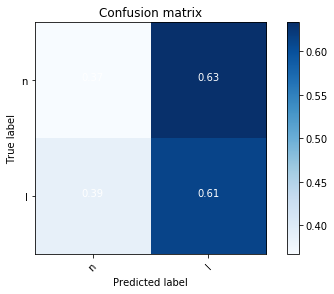

In [70]:
pred = list()
for p in predictions:
    pred.append(p["class_ids"][0])
    
cm = confusion_matrix(y_test, pred)

print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))
plot_confusion_matrix(cm, classes, normalize=True)

### Keras Training

1. Define the sequential model that is used to train.

2. Set of neural network layers

In [55]:
### Separate the dataset into training and testing.
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import backend as K

x_train, x_test, y_train, y_test = train_test_split(X_H0, Y_H0, test_size=0.1)
print("x_train : ", len(x_train))
print("x_test  : ", len(x_test))
print("y_train : ", collections.Counter(y_train))
print("y_test  : ", collections.Counter(y_test))
## Print train & test
print(np.shape(x_train[0]))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))
# Normalize
# x_train = normalize(x_train, axis=0, norm='max')
# x_test = normalize(x_test, axis=0, norm='max')
y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)

x_train :  8410
x_test  :  935
y_train :  Counter({1: 5081, 0: 3329})
y_test  :  Counter({1: 572, 0: 363})
(10001,)
(8410,)
(935, 10001)
(935,)


In [59]:
### Define F1 metric
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [63]:
### Keras Sequential Models
model = Sequential()
model.add(Dense(128, input_dim=10001, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 128)               1280256   
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
__________

In [64]:
### Compilation
# For a binary classification problem
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy', f1])

In [65]:
## Run the model
model.fit(x_train, y_train, epochs=20, batch_size=128)
score = model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/20
8410/8410 [==============================] - 6s 763us/step - loss: 0.7376 - acc: 0.5154 - f1: 0.5442
Epoch 2/20
8410/8410 [==============================] - 1s 62us/step - loss: 0.7005 - acc: 0.5649 - f1: 0.5753
Epoch 3/20
8410/8410 [==============================] - 1s 61us/step - loss: 0.6889 - acc: 0.5826 - f1: 0.5889
Epoch 4/20
8410/8410 [==============================] - 1s 62us/step - loss: 0.6851 - acc: 0.5897 - f1: 0.5926
Epoch 5/20
8410/8410 [==============================] - 1s 62us/step - loss: 0.6793 - acc: 0.5954 - f1: 0.5982
Epoch 6/20
8410/8410 [==============================] - 1s 62us/step - loss: 0.6754 - acc: 0.5999 - f1: 0.6017
Epoch 7/20
8410/8410 [==============================] - 1s 61us/step - loss: 0.6730 - acc: 0.5986 - f1: 0.5997
Epoch 8/20
8410/8410 [==============================] - 1s 61us/step - loss: 0.6702 - acc: 0.6028 - f1: 0.6026
Epoch 9/20
8410/8410 [==============================] - 1s 61us/step - loss: 0.6719 - acc: 0.6060 - f1: 0.6054


In [66]:
score

[0.6378572471001569, 0.6449197872437258, 0.6438818117514014]